# Nipype Hands-on: How to create an fMRI preprocessing workflow

The purpose of this section is that you setup a fMRI pre-processing workflow yourself. We want to highlight that this pipeline is only an abbreviated version of a real fMRI pre-processing pipeline. We took some short cuts to keep the computation time to a minimum. For a more realistic example, check out the Hands-on example from the [Nipype Tutorial](https://miykael.github.io/nipype_tutorial/) or the fully automatic state-of-the-art pre-processing pipeline [fmriprep](http://fmriprep.readthedocs.io/en/latest/).

# Preprocessing Workflow Structure

So let's get our hands dirty. First things first, it's always good to know which interfaces you want to use in your workflow and in which order you want to execute them. For this pre-processing workflow, I recommend that we use the following nodes:

     1. Extract Brain from Anatomical Image
     2. Segment Brain
     3. Normalize Brain to MNI-Template
     4. Motion Correct Functional Image
     5. Coregister Functional Image to Anatomy
     6. Normalize Functional Image to MNI-Template
     7. Smooth Functional Image

## Imports

It's always best to have all relevant module imports at the beginning of your script. So let's import what we most certainly need.

In [1]:
# Get the Node and Workflow object
from nipype import Node, Workflow

/opt/miniconda-latest/envs/neuro/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/miniconda-latest/envs/neuro/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Create Nodes and Workflow connections

Let's create all the nodes that we need! Make sure to specify all relevant inputs and keep in mind which ones you later on need to connect in your pipeline.

### Workflow

We recommend to create the workflow and establish all it's connections at a later place in your script. This helps to have everything nicely together. But for this hands-on example it makes sense to establish the connections between the nodes as we go.

And for this, we first need to create a workflow:

In [2]:
# Create the workflow here
# Hint: use 'base_dir' to specify where to store the working directory

In [3]:
preproc = Workflow(name='work_preproc', base_dir='/output/')

### Extract the Brain

For certain processing steps it's better to just have the brain, without the skull and rest of the head. This can be done by extracting the brain from the anatomical raw image. So let's implement a node that does that.

In [4]:
from nipype.interfaces.fsl import BET

In [5]:
# Initiate Gunzip node
brain_extract_anat = Node(BET(frac=0.2), name='brain_extract_anat')

We've already created the brain extraction node for you. It serves as a template for the other nodes to come.

### Segment Anatomical Image

For the image coregistration between functional and anatomical images we will need the white matter (WM) segmentation of the anatomical image. So let's implement a node that does exactly that.

In [6]:
from nipype.interfaces.fsl import FAST

In [7]:
# Initiate Segmentation node here

In [8]:
segmentation = Node(FAST(segments=True, no_pve=True, no_bias=True),
                    name='segmentation')

Now the next step is to connect the `segmentation` node to the rest of the workflow, i.e. the `brain_extract_anat` node from before.

In [9]:
# Connect Segmentation node to anatomical brain extraction node here

In [10]:
preproc.connect([(brain_extract_anat, segmentation, [('out_file', 'in_files')])])

### Normalize Anatomical Image to MNI-Template

In the end we want to have all data in a common reference space. In MRI this is usually the MNI-Template. This will allow us to compare the brains of different subjects with each other. So let's implement the node that computes the transformation matrix that maps the subject brain onto the template brain.

In [11]:
from nipype.interfaces.fsl import FLIRT

In [12]:
# Initate normalize node here

In [13]:
mni_template = '/templates/MNI152_T1_1mm.nii.gz'
normalize = Node(FLIRT(reference=mni_template), name="normalize")

We will connect the input to this node at a later stage.

### Motion Correction of Functional Image

Let us now focus on the functional image. First, let's correct for the motion during data recording. It's normal that a subject moves their head a bit in the scanner. Therefore, an important step in fMRI pre-processing is to correct for this head motion. So let's implement the node that does exactly that.

In [14]:
from nipype.interfaces.fsl import MCFLIRT

In [15]:
# Initate motion correction node here

In [16]:
motion_correction = Node(MCFLIRT(mean_vol=True,
                                 save_plots=True),
                         name="motion_correction")

We will connect the input to this node at a later stage.

### Compute Coregistration Matrix

As a next step we will make sure that the functional images are coregistered to the anatomical image. For this we will use FSL's `FLIRT` function. As we just created a white matter probability map, we can use this together with the a Boundary-Based Registration (BBR) cost function to optimize the image coregistration. As some helpful notes...
- use a degree of freedom of 6
- specify the cost function as `bbr`
- use the `schedule='/usr/share/fsl/5.0/etc/flirtsch/bbr.sch'`

In [17]:
from nipype.interfaces.fsl import FLIRT

In [18]:
# Initate coregistration node here

In [19]:
coregistration = Node(FLIRT(dof=6,
                            cost='bbr',
                            schedule='/usr/share/fsl/5.0/etc/flirtsch/bbr.sch',
                            output_type='NIFTI'),
                      name="coregistration")

In [20]:
# Connect coregistration node to the other nodes here

In [21]:
preproc.connect([(motion_correction, coregistration, [('mean_img', 'in_file')])])

As mentioned above, the `bbr` routine can use the subject specific white matter mask to guide the coregistration. The problem is that the `segmentation` node above gives us back a list of files, i.e. `['CSF_mask', 'GM_mask', 'WM_mask']`.

The masks that we're interested in is the last one. Let us therefore write a short function that gives us back the last element of a list:

In [22]:
# Select WM segmentation file from segmentation output
def get_wm(files):
    return files[-1]

Now that we have that we can connect the `segmentation` node to the `coregistration` node:

In [23]:
# Connecting the segmentation node with the coregistration node
preproc.connect([(segmentation, coregistration, [(('tissue_class_files', get_wm),
                                                  'wm_seg')])])

### Apply Coregistration Matrix to functional image

Now that we know the coregistration matrix to correctly overlay the functional mean image on the subject specific anatomy, we need to apply to coregistration to the whole time series. This can be achieved with FSL's `FLIRT` as follows:

In [24]:
# Specify the isometric voxel resolution you want after coregistration
desired_voxel_iso = 4

# Apply coregistration warp to functional images
apply_coregistration = Node(FLIRT(interp='spline',
                                  apply_isoxfm=desired_voxel_iso),
                            name="apply_coregistration")

**<span style="color:red">Important</span>**: As you can see above, we also specified a variable `desired_voxel_iso`. This is very important at this stage, otherwise `FLIRT` will transform your functional images to a resolution of the anatomical image, which will dramatically increase the file size (e.g. to 1-10GB per file). If you don't want to change the voxel resolution, use the `no_resample=True` value instead of `apply_isoxfm=desired_voxel_iso`.

In [25]:
# Connecting the ApplyWarp node to all the other nodes
preproc.connect([(motion_correction, apply_coregistration, [('out_file', 'in_file')]),
                 (coregistration, apply_coregistration, [('out_matrix_file', 'in_matrix_file')])
                 ])

### Apply Normalization Matrix to functional image

After the functional images were coregistered to the anatomical image we can apply the normalization matrix to get the functional images into MNI-Template space. This step is almost identical as before, so let's not forget the `apply_isoxfm=desired_voxel_iso` command.

In [26]:
# Apply normalization warp to functional images
apply_normalization = Node(FLIRT(interp='spline',
                                 apply_isoxfm=desired_voxel_iso,
                                 reference=mni_template),
                           name="apply_normalization")

Let's now connect the `apply_normalization` node to the other nodes.

In [27]:
# Connecting the ApplyWarp node to all the other nodes
preproc.connect([(apply_coregistration, apply_normalization, [('out_file', 'in_file')]),
                 (normalize, apply_normalization, [('out_matrix_file', 'in_matrix_file')])
                 ])

### Smoothing

Next step is image smoothing. The extend of smoothing depends on what kind of analysis you want to perform later on. For machine learning approaches it is recommended not to smooth too much, so let's choose a smoothing kernel with a `FWHM` parameter of 2mm.

In [28]:
from nipype.interfaces.fsl import Smooth

In [29]:
# Initate smooth node here

In [30]:
smooth = Node(Smooth(fwhm=2), name="smooth")

In [31]:
# Connect smooth node to normalize node above here

In [32]:
preproc.connect([(apply_normalization, smooth, [('out_file', 'in_file')])])

## Datainput with `IdentityInterface`, `iterables` and `SelectFiles`

This is all nice and well. But so far we don't have any data in our workflow. We could sepcify the required input files manually, but that would be tiresome. So how can we scale this up to multiple subjects and multiple functional images?

The solution is [`IdentityInterface`](https://miykael.github.io/nipype_tutorial/notebooks/basic_iteration.html#IdentityInterface-(special-use-case-of-iterables), [`iterables`](https://miykael.github.io/nipype_tutorial/notebooks/basic_iteration.html) and [`SelectFiles`](https://miykael.github.io/nipype_tutorial/notebooks/basic_data_input.html#SelectFiles)! It's rather simple, specify a template and fill-up the placeholder variables.

In [33]:
# Import the SelectFiles
from nipype import SelectFiles

# String template with {}-based strings
anat_template = {'anat': 'sub-{subject_id}/anat/sub-{subject_id}_T1w.nii.gz'}
func_template = {'func': 'sub-{subject_id}/func/sub-{subject_id}_task-rest-{task_id}_bold.nii.gz'}

# Create SelectFile node for anatomical images
select_anat = Node(SelectFiles(anat_template,
                               base_directory='/data/dataset',
                               sort_filelist=True),
                   name='select_anat')

# Create SelectFile node for functional images
select_func = Node(SelectFiles(func_template,
                               base_directory='/data/dataset',
                               sort_filelist=True),
                   name='select_func')

Now that we have the data template ready we can specify over which subjects and runs the workflow should iterate.

In [34]:
# To test the workflow, let's just look at subject 01
subject_list = ['01']

# Iterate over the two different functional sessions 'Eye closed' and 'Eyes open'
task_list = ['EC', 'EO'] 
select_func.iterables = [('task_id', task_list)]

Now we just have to iterate over those two lists and connect the nodes to the workflow.

In [35]:
# Import the IdentityInterface
from nipype.interfaces.utility import IdentityInterface

info_source = Node(IdentityInterface(fields=['subject_id']),
                   name="info_source")
info_source.iterables = [('subject_id', subject_list)]

In [36]:
# Connect IdentityInterface and SelectFiles nodes to the rest of the workflow

In [37]:
preproc.connect([(info_source, select_anat, [('subject_id', 'subject_id')]),
                 (info_source, select_func, [('subject_id', 'subject_id')]),
                 (select_anat, brain_extract_anat, [('anat', 'in_file')]),
                 (select_anat, normalize, [('anat', 'in_file')]),
                 (select_anat, coregistration, [('anat', 'reference')]),
                 (select_anat, apply_coregistration, [('anat', 'reference')]),
                 (select_func, motion_correction, [('func', 'in_file')])
                 ])

## Data output with `DataSink`

The execution of the workflow will create a lot of temporary files. You will have an additional copy of your MRI images in almost every node. So let's use a `Datasink` to keep only those files that we actually need. Like this we can later on delete everything that is in the working directory.

In [38]:
from nipype.interfaces.io import DataSink

# Initiate the datasink node
output_folder = 'datasink'
datasink = Node(DataSink(base_directory='/output/',
                         container='datasink'),
                name="datasink")

Now the next step is to specify all the output that we want to keep in our output folder `output`.

In [39]:
preproc.connect([(brain_extract_anat, datasink, [('out_file', 'preproc.@brain')]),
                 (segmentation, datasink, [('tissue_class_files', 'preproc.@segments')]),
                 (motion_correction, datasink, [('par_file', 'preproc.@motion_parameter')]),
                 (normalize, datasink, [('out_file', 'preproc.@norm_anat')]),
                 (smooth, datasink, [('smoothed_file', 'preproc.@func')])
                 ])

We're almost ready to run the workflow. The last thing that we need to do is specifying text substitutions for the datasink. If we don't do this, than files might be called `_subject_id_sub-01_task_id_task-rest-EC_bold_flirt_flirt_brain.nii.gz` or similar. To prevent this, we can use `substitutions`. For this, we create a list of tuples: on the left we specify the string that we want to replace and on the right, with what we want to replace it with.

In [40]:
## Use the following substitutions for the DataSink output
substitutions = [('_flirt', ''),
                 ('_bold', ''),
                 ('_mcf', ''),
                 ('T1w_brain_seg_0', 'seg_csf'),
                 ('T1w_brain_seg_1', 'seg_gm'),
                 ('T1w_brain_seg_2', 'seg_wm'),
                 ('.nii.gz.par', '.par'),
                 ]

# To get rid of the folder '_subject_id_07' and renaming detrend
substitutions += [('_subject_id_%s/' % s, '') for s in subject_list]
substitutions += [('_task_id_%s' % r, '') for r in task_list]
datasink.inputs.substitutions = substitutions

## Visualize the workflow

Now that we're done. Let's look at the workflow that we just created.

180817-11:49:50,568 nipype.workflow INFO:
	 Generated workflow graph: /output/work_preproc/graph.png (graph2use=colored, simple_form=True).


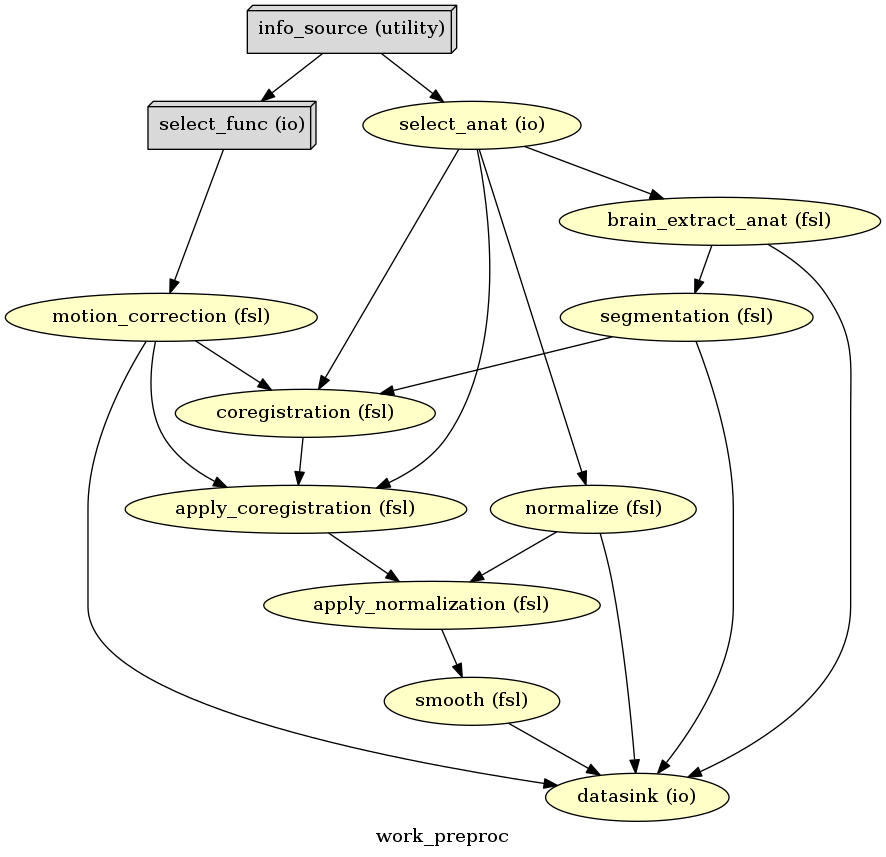

In [41]:
# Create preproc output graph
preproc.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename='/output/work_preproc/graph.png', width=750)

##  Run the Workflow

Now we are ready to run the workflow! Be careful about the `n_procs` parameter if you run a workflow in `'MultiProc'` mode. `n_procs` specifies the number of jobs/cores your computer will use to run the workflow. If this number is too high your computer will try to execute too many things at once and will most likely crash.

**Note**: If  you're using a Docker container and FLIRT fails to run without any good reason, you might need to change memory settings in the Docker preferences (4 GB should be enough for this workflow).

In [42]:
%time preproc.run('MultiProc', plugin_args={'n_procs': 4})

180817-11:49:50,618 nipype.workflow INFO:
	 Workflow work_preproc settings: ['check', 'execution', 'logging', 'monitoring']
180817-11:49:50,651 nipype.workflow INFO:
	 Running in parallel.
180817-11:49:50,655 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 3 jobs ready. Free memory (GB): 53.94/53.94, Free processors: 4/4.
180817-11:49:50,710 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.select_anat" in "/output/work_preproc/_subject_id_01/select_anat".180817-11:49:50,713 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.select_func" in "/output/work_preproc/_subject_id_01/_task_id_EC/select_func".180817-11:49:50,711 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.select_func" in "/output/work_preproc/_subject_id_01/_task_id_EO/select_func".


180817-11:49:50,754 nipype.workflow INFO:
	 [Node] Running "select_func" ("nipype.interfaces.io.SelectFiles")180817-11:49:50,753 nipype.workflow INFO:
	 [Node] Running "select_func" ("nipype.interfaces.io.SelectFil

flirt -in /output/work_preproc/_subject_id_01/_task_id_EO/motion_correction/sub-01_task-rest-EO_bold_mcf.nii.gz_mean_reg.nii.gz -ref /data/dataset/sub-01/anat/sub-01_T1w.nii.gz -out sub-01_task-rest-EO_bold_mcf.nii.gz_mean_reg_flirt.nii -omat sub-01_task-rest-EO_bold_mcf.nii.gz_mean_reg_flirt.mat -cost bbr -dof 6 -schedule /usr/share/fsl/5.0/etc/flirtsch/bbr.sch -wmseg /output/work_preproc/_subject_id_01/segmentation/sub-01_T1w_brain_seg_2.nii.gz

180817-11:50:50,715 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 0 jobs ready. Free memory (GB): 53.54/53.94, Free processors: 2/4.
                     Currently running:
                       * work_preproc.coregistration
                       * work_preproc.coregistration
180817-11:52:23,732 nipype.workflow INFO:
	 [Node] Finished "work_preproc.coregistration".
180817-11:52:24,799 nipype.workflow INFO:
	 [Job 6] Completed (work_preproc.coregistration).
180817-11:52:24,803 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, a

180817-11:52:51,169 nipype.workflow INFO:
	 [Node] Finished "work_preproc.apply_coregistration".
180817-11:52:52,821 nipype.workflow INFO:
	 [Job 14] Completed (work_preproc.apply_coregistration).
180817-11:52:52,829 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 53.94/53.94, Free processors: 4/4.
180817-11:52:52,888 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.apply_normalization" in "/output/work_preproc/_subject_id_01/_task_id_EC/apply_normalization".
180817-11:52:52,895 nipype.workflow INFO:
	 [Node] Running "apply_normalization" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /output/work_preproc/_subject_id_01/_task_id_EC/apply_coregistration/sub-01_task-rest-EC_bold_mcf_flirt.nii.gz -ref /templates/MNI152_T1_1mm.nii.gz -out sub-01_task-rest-EC_bold_mcf_flirt_flirt.nii.gz -omat sub-01_task-rest-EC_bold_mcf_flirt_flirt.mat -applyisoxfm 4.000000 -init /output/work_preproc/_subject_id_01

## Inspect output

What did we actually do? Let's look at all the data that we created.

In [43]:
!tree /output/datasink/preproc

/output/datasink/preproc
├── sub-01_seg_csf.nii.gz
├── sub-01_seg_gm.nii.gz
├── sub-01_seg_wm.nii.gz
├── sub-01_T1w_brain.nii.gz
├── sub-01_T1w.nii.gz
├── sub-01_task-rest-EC.par
├── sub-01_task-rest-EC_smooth.nii.gz
├── sub-01_task-rest-EO.par
├── sub-01_task-rest-EO_smooth.nii.gz
├── sub-02_seg_csf.nii.gz
├── sub-02_seg_gm.nii.gz
├── sub-02_seg_wm.nii.gz
├── sub-02_T1w_brain.nii.gz
├── sub-02_T1w.nii.gz
├── sub-02_task-rest-EC.par
├── sub-02_task-rest-EC_smooth.nii.gz
├── sub-02_task-rest-EO.par
├── sub-02_task-rest-EO_smooth.nii.gz
├── sub-03_seg_csf.nii.gz
├── sub-03_seg_gm.nii.gz
├── sub-03_seg_wm.nii.gz
├── sub-03_T1w_brain.nii.gz
├── sub-03_T1w.nii.gz
├── sub-03_task-rest-EC.par
├── sub-03_task-rest-EC_smooth.nii.gz
├── sub-03_task-rest-EO.par
└── sub-03_task-rest-EO_smooth.nii.gz

0 directories, 27 files


That's a lot... But what did we exactly do? Well, let's investigate.

### Brain Extraction of anatomical image

First, how well did the brain extraction on the anatomical image work?

In [44]:
from nilearn.plotting import plot_stat_map
%matplotlib inline

/opt/miniconda-latest/envs/neuro/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/miniconda-latest/envs/neuro/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


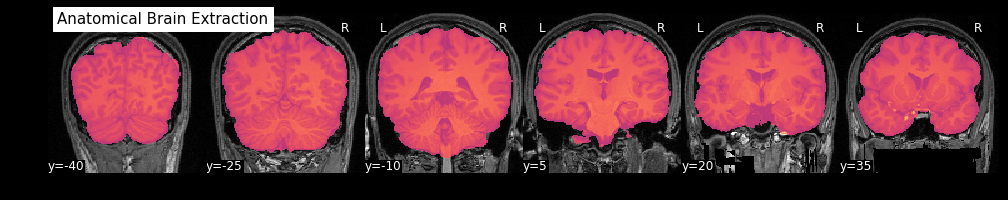

In [45]:
anat_file = '/data/dataset/sub-01/anat/sub-01_T1w.nii.gz'
anat_brain = '/output/datasink/preproc/sub-01_T1w_brain.nii.gz'

plot_stat_map(anat_brain, title='Anatomical Brain Extraction',  cmap='magma', bg_img=anat_file,
              display_mode='y', cut_coords=range(-40, 36, 15), dim=-1, colorbar=False);

Seems great! It was mostly able to extract the brain from the rest of the anatomical image.

### Brain Segmentation

And how well did the brain segmentation work?

In [46]:
import nibabel as nb
import numpy as np

anat_img = nb.load(anat_file)
gm_img = nb.load('/output/datasink/preproc/sub-01_seg_gm.nii.gz')
wm_img = nb.load('/output/datasink/preproc/sub-01_seg_wm.nii.gz')
csf_img = nb.load('/output/datasink/preproc/sub-01_seg_csf.nii.gz')

data = np.stack((np.zeros(anat_img.get_data().shape[:3]),
                 gm_img.get_data(),
                 wm_img.get_data(),
                 csf_img.get_data()), axis= -1)

label_id = np.argmax(data, axis=-1)
segmentation = nb.Nifti1Image(label_id, anat_img.affine, anat_img.header)

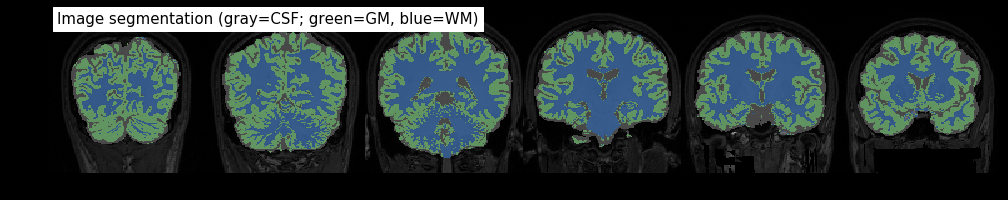

In [47]:
from nilearn.plotting import plot_roi
plot_roi(segmentation, cmap='Accent', dim=1, annotate=False, bg_img=anat_img,
         display_mode='y', title='Image segmentation (gray=CSF; green=GM, blue=WM)',
         resampling_interpolation='nearest', cut_coords=range(-40, 36, 15))

### Anatomical Normalization

We've also computed the transformation matrix to normalize the anatomical image to a MNI template space. Let's see how well this worked?

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/scipy/signal/signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()


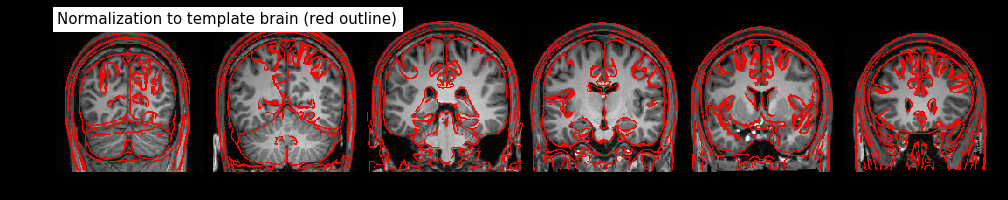

In [48]:
from nilearn.plotting import plot_anat

anat_norm = '/output/datasink/preproc/sub-01_T1w.nii.gz'
ref_norm = '/templates/MNI152_T1_1mm.nii.gz'

# Plot normalized subject anatomy
display = plot_anat(anat_norm, title='Normalization to template brain (red outline)',
                    display_mode='y', cut_coords=range(-75, 36, 20), dim=-1, colorbar=False,
                    resampling_interpolation='nearest', annotate=False)

# Overlay in edges GM map
display.add_edges(ref_norm)

### Motion Correction

How much did the subject move in the scanner?

In [49]:
%matplotlib inline

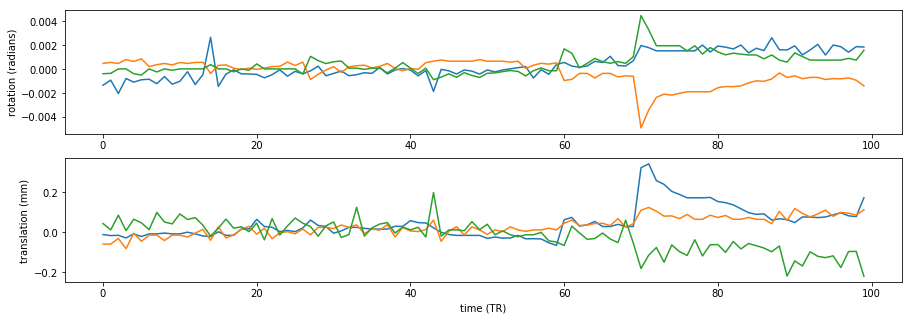

In [50]:
# Plot the motion paramters
import numpy as np
import matplotlib.pyplot as plt
par = np.loadtxt('/output/datasink/preproc/sub-01_task-rest-EC.par')
fig, axes = plt.subplots(2, 1, figsize=(15, 5))
axes[0].set_ylabel('rotation (radians)')
axes[0].plot(par[0:, :3])
axes[1].plot(par[0:, 3:])
axes[1].set_xlabel('time (TR)')
axes[1].set_ylabel('translation (mm)');

The motion parameters seem to look ok.

### Functional Image transformations

We did many different things to our functional images. Let's take a look how well this worked.

In [51]:
from nilearn.image import mean_img

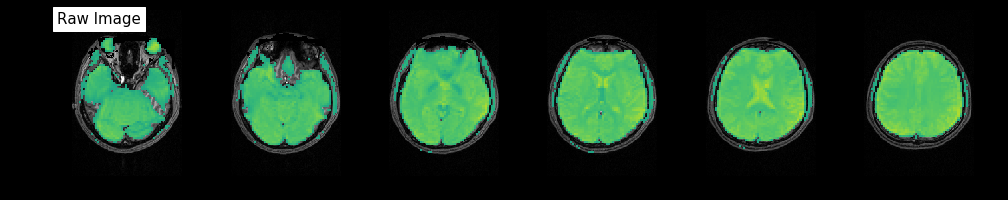

In [52]:
plot_stat_map(mean_img('/data/dataset/sub-01/func/sub-01_task-rest-EC_bold.nii.gz'),
              title='Raw Image',  cmap='viridis', bg_img=anat_file,
              display_mode='z', cut_coords=range(-10, 41, 10), dim=-1, colorbar=False,
              annotate=False, threshold=300);

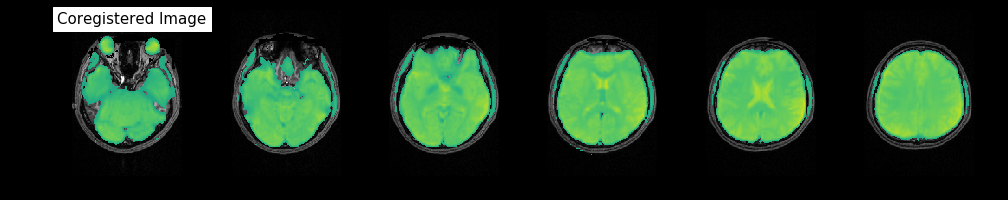

In [53]:
coreg_file = '/output/work_preproc/_subject_id_01/_task_id_EC/coregistration/'
coreg_file += 'sub-01_task-rest-EC_bold_mcf.nii.gz_mean_reg_flirt.nii'
plot_stat_map(mean_img(coreg_file),
              title='Coregistered Image',  cmap='viridis', bg_img=anat_file,
              display_mode='z', cut_coords=range(-10, 41, 10), dim=-1, colorbar=False,
              annotate=False, threshold=300);

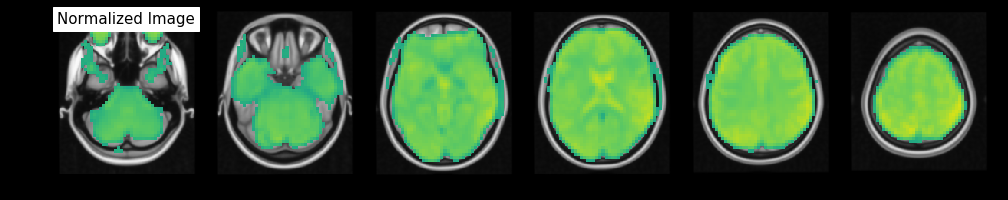

In [54]:
norm_file = '/output/work_preproc/_subject_id_01/_task_id_EC/apply_normalization/'
norm_file += 'sub-01_task-rest-EC_bold_mcf_flirt_flirt.nii.gz'
plot_stat_map(mean_img(norm_file),
              title='Normalized Image',  cmap='viridis', bg_img='/templates/MNI152_T1_1mm.nii.gz',
              display_mode='z', cut_coords=range(-45, 56, 20), dim=0, colorbar=False,
              annotate=False, threshold=300);

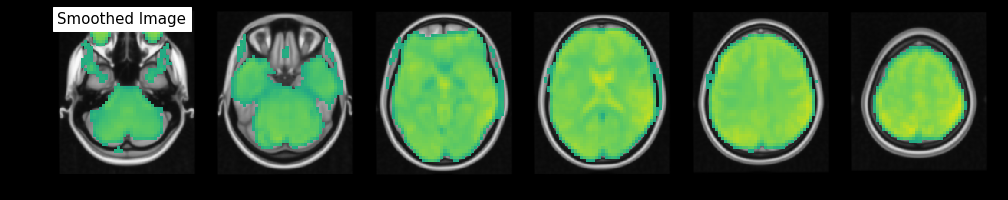

In [55]:
smooth_file = '/output/datasink/preproc/sub-01_task-rest-EC_smooth.nii.gz'
plot_stat_map(mean_img(smooth_file),
              title='Smoothed Image',  cmap='viridis', bg_img='/templates/MNI152_T1_1mm.nii.gz',
              display_mode='z', cut_coords=range(-45, 56, 20), dim=0, colorbar=False,
              annotate=False, threshold=300);

## Run Preprocessing workflow on all subjects

Perfect! Now that we know that everything works fine we can run the pre-processing pipeline on all three subjects. For this you just need to change the `subject_list` variable and run again the places where this variable is used (i.e. `select_anat.iterables`, `select_func.iterables` and in `DataSink` `substitutions`.

In [56]:
# Update 'subject_list' and its dependencies here

In [57]:
subject_list = ['01', '02', '03']
info_source.iterables = [('subject_id', subject_list)]

In [58]:
substitutions += [('_subject_id_%s/' % s, '') for s in subject_list]
datasink.inputs.substitutions = substitutions

Now we can run the workflow again, this time for all subjects in parallel.

In [59]:
# Runs the preprocessing workflow again, this time with substitutions
%time preproc.run('MultiProc', plugin_args={'n_procs': 4})

180817-11:53:21,968 nipype.workflow INFO:
	 Workflow work_preproc settings: ['check', 'execution', 'logging', 'monitoring']
180817-11:53:22,48 nipype.workflow INFO:
	 Running in parallel.
180817-11:53:22,52 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 9 jobs ready. Free memory (GB): 53.94/53.94, Free processors: 4/4.
180817-11:53:22,153 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.select_anat" in "/output/work_preproc/_subject_id_03/select_anat".180817-11:53:22,154 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.select_func" in "/output/work_preproc/_subject_id_02/_task_id_EC/select_func".

180817-11:53:22,161 nipype.workflow INFO:
	 [Node] Running "select_func" ("nipype.interfaces.io.SelectFiles")180817-11:53:22,161 nipype.workflow INFO:
	 [Node] Running "select_anat" ("nipype.interfaces.io.SelectFiles")

180817-11:53:22,170 nipype.workflow INFO:
	 [Node] Finished "work_preproc.select_func".180817-11:53:22,170 nipype.workflow INFO:
	 [Node] Finished "wor

mcflirt -in /data/dataset/sub-02/func/sub-02_task-rest-EO_bold.nii.gz -meanvol -out /output/work_preproc/_subject_id_02/_task_id_EO/motion_correction/sub-02_task-rest-EO_bold_mcf.nii.gz -plots
180817-11:54:02,84 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 4 jobs ready. Free memory (GB): 53.14/53.94, Free processors: 0/4.
                     Currently running:
                       * work_preproc.motion_correction
                       * work_preproc.motion_correction
                       * work_preproc.segmentation
                       * work_preproc.normalize
180817-11:54:08,819 nipype.workflow INFO:
	 [Node] Finished "work_preproc.normalize".
180817-11:54:10,90 nipype.workflow INFO:
	 [Job 5] Completed (work_preproc.normalize).
180817-11:54:10,93 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 4 jobs ready. Free memory (GB): 53.34/53.94, Free processors: 1/4.
                     Currently running:
                       * work_preproc.motion_correction
 

180817-11:55:09,9 nipype.workflow INFO:
	 [Node] Finished "work_preproc.normalize".
180817-11:55:10,147 nipype.workflow INFO:
	 [Job 23] Completed (work_preproc.normalize).
180817-11:55:10,150 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 3 jobs ready. Free memory (GB): 53.34/53.94, Free processors: 1/4.
                     Currently running:
                       * work_preproc.segmentation
                       * work_preproc.coregistration
                       * work_preproc.coregistration
180817-11:55:10,212 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.select_func" in "/output/work_preproc/_subject_id_01/_task_id_EC/select_func".
180817-11:55:10,217 nipype.workflow INFO:
	 [Node] Running "select_func" ("nipype.interfaces.io.SelectFiles")
180817-11:55:10,224 nipype.workflow INFO:
	 [Node] Finished "work_preproc.select_func".
180817-11:55:12,149 nipype.workflow INFO:
	 [Job 36] Completed (work_preproc.select_func).
180817-11:55:12,151 nipype.workflow INFO:


flirt -in /output/work_preproc/_subject_id_02/_task_id_EO/motion_correction/sub-02_task-rest-EO_bold_mcf.nii.gz_mean_reg.nii.gz -ref /data/dataset/sub-02/anat/sub-02_T1w.nii.gz -out sub-02_task-rest-EO_bold_mcf.nii.gz_mean_reg_flirt.nii -omat sub-02_task-rest-EO_bold_mcf.nii.gz_mean_reg_flirt.mat -cost bbr -dof 6 -schedule /usr/share/fsl/5.0/etc/flirtsch/bbr.sch -wmseg /output/work_preproc/_subject_id_02/segmentation/sub-02_T1w_brain_seg_2.nii.gz

180817-11:55:36,243 nipype.workflow INFO:
	 [Node] Running "coregistration" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /output/work_preproc/_subject_id_02/_task_id_EC/motion_correction/sub-02_task-rest-EC_bold_mcf.nii.gz_mean_reg.nii.gz -ref /data/dataset/sub-02/anat/sub-02_T1w.nii.gz -out sub-02_task-rest-EC_bold_mcf.nii.gz_mean_reg_flirt.nii -omat sub-02_task-rest-EC_bold_mcf.nii.gz_mean_reg_flirt.mat -cost bbr -dof 6 -schedule /usr/share/fsl/5.0/etc/flirtsch/bbr.sch -wmseg /output/work_prepr

180817-11:56:40,299 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.datasink" in "/output/work_preproc/_subject_id_03/_task_id_EO/datasink".
180817-11:56:40,307 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
180817-11:56:40,310 nipype.interface INFO:
	 sub: /output/datasink/preproc/_subject_id_03/_task_id_EO/sub-03_task-rest-EO_bold_mcf.nii.gz.par -> /output/datasink/preproc//sub-03_task-rest-EO.par
180817-11:56:40,315 nipype.interface INFO:
	 sub: /output/datasink/preproc/_subject_id_03/sub-03_T1w_brain.nii.gz -> /output/datasink/preproc/sub-03_T1w_brain.nii.gz
180817-11:56:40,335 nipype.interface INFO:
	 sub: /output/datasink/preproc/_subject_id_03/sub-03_T1w_flirt.nii.gz -> /output/datasink/preproc/sub-03_T1w.nii.gz
180817-11:56:40,396 nipype.interface INFO:
	 sub: /output/datasink/preproc/_subject_id_03/_task_id_EO/sub-03_task-rest-EO_bold_mcf_flirt_flirt_smooth.nii.gz -> /output/datasink/preproc//sub-03_task-rest-EO_smooth.nii.gz
180817

180817-11:57:38,340 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.apply_coregistration" in "/output/work_preproc/_subject_id_02/_task_id_EO/apply_coregistration".
180817-11:57:38,346 nipype.workflow INFO:
	 [Node] Running "apply_coregistration" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /output/work_preproc/_subject_id_02/_task_id_EO/motion_correction/sub-02_task-rest-EO_bold_mcf.nii.gz -ref /data/dataset/sub-02/anat/sub-02_T1w.nii.gz -out sub-02_task-rest-EO_bold_mcf_flirt.nii.gz -omat sub-02_task-rest-EO_bold_mcf_flirt.mat -applyisoxfm 4.000000 -init /output/work_preproc/_subject_id_02/_task_id_EO/coregistration/sub-02_task-rest-EO_bold_mcf.nii.gz_mean_reg_flirt.mat -interp spline
180817-11:57:40,285 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 0 jobs ready. Free memory (GB): 53.54/53.94, Free processors: 2/4.
                     Currently running:
                       * work_preproc.apply_coregistration
      

	 sub: /output/datasink/preproc/_subject_id_02/sub-02_T1w_brain_seg_0.nii.gz -> /output/datasink/preproc/sub-02_seg_csf.nii.gz
180817-11:58:00,720 nipype.interface INFO:
	 sub: /output/datasink/preproc/_subject_id_02/sub-02_T1w_brain_seg_1.nii.gz -> /output/datasink/preproc/sub-02_seg_gm.nii.gz
180817-11:58:00,726 nipype.interface INFO:
	 sub: /output/datasink/preproc/_subject_id_02/sub-02_T1w_brain_seg_2.nii.gz -> /output/datasink/preproc/sub-02_seg_wm.nii.gz
180817-11:58:00,733 nipype.workflow INFO:
	 [Node] Finished "work_preproc.datasink".
180817-11:58:02,304 nipype.workflow INFO:
	 [Job 30] Completed (work_preproc.datasink).
180817-11:58:02,307 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 53.74/53.94, Free processors: 3/4.
                     Currently running:
                       * work_preproc.smooth
180817-11:58:04,361 nipype.workflow INFO:
	 [Node] Finished "work_preproc.smooth".
180817-11:58:06,310 nipype.workflow INFO:
	 [Job 3

# Verification of Results

To make sure that the pre-processing of all subjects werekd well, let's quickly plot the anatomical brain extraction, as well as the normalized and smoothed functional images:

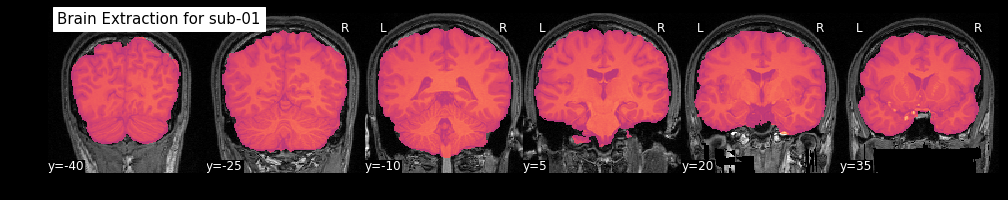

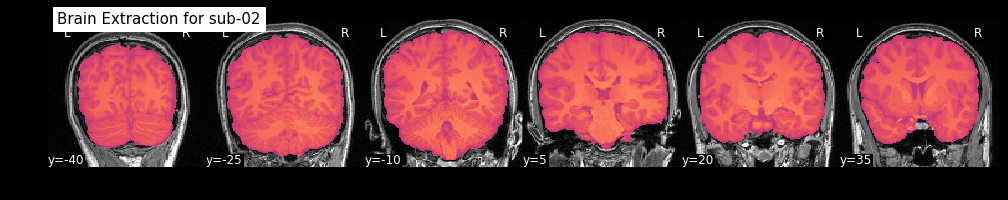

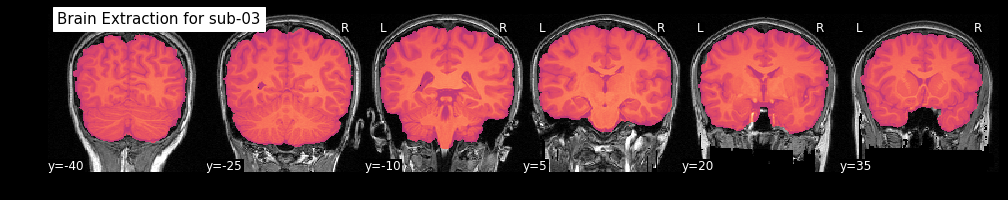

In [60]:
for sub in subject_list:

    anat_file = '/data/dataset/sub-%s/anat/sub-%s_T1w.nii.gz' % (sub, sub)
    anat_brain = '/output/datasink/preproc/sub-%s_T1w_brain.nii.gz' % sub

    plot_stat_map(anat_brain, title='Brain Extraction for sub-%s' % sub,  cmap='magma', bg_img=anat_file,
                  display_mode='y', cut_coords=range(-40, 36, 15), dim=-1, colorbar=False);

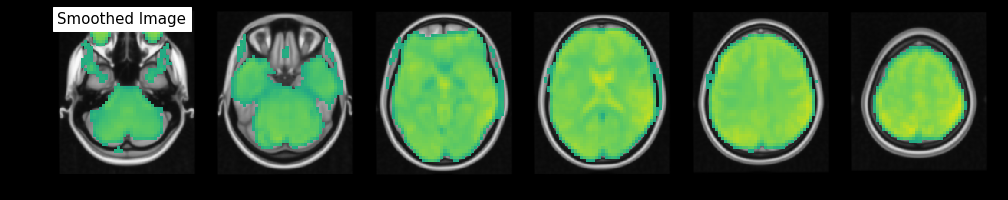

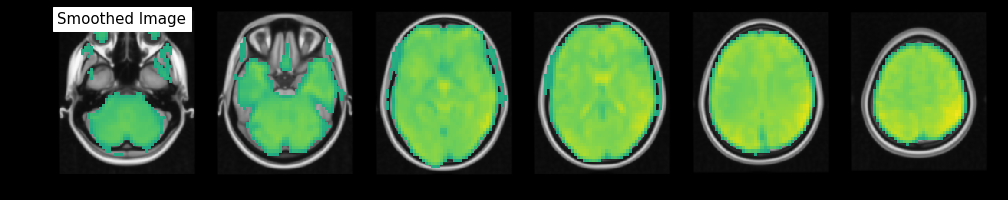

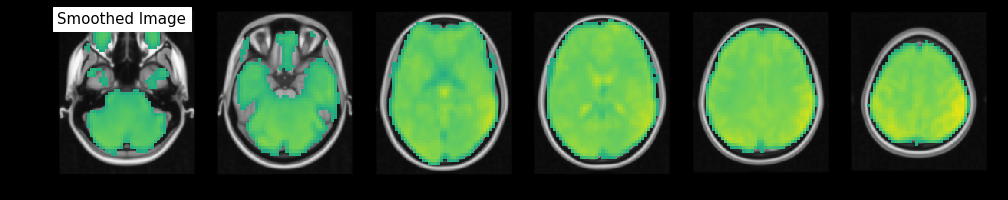

In [61]:
for sub in subject_list:

    smooth_file = '/output/datasink/preproc/sub-%s_task-rest-EC_smooth.nii.gz' % sub
    plot_stat_map(mean_img(smooth_file),
                  title='Smoothed Image',  cmap='viridis', bg_img='/templates/MNI152_T1_1mm.nii.gz',
                  display_mode='z', cut_coords=range(-45, 56, 20), dim=0, colorbar=False,
                  annotate=False, threshold=300);